# L5: Regularization

112501533 黃思誠

link: https://nthu-datalab.github.io/ml/labs/05_Regularization/05_Regularization.html


## Load Package


In [1]:
import csv
import urllib.request
import warnings
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.experimental import enable_halving_search_cv
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import HalvingRandomSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")


In [2]:
# Some constants
RANDOM_STATE = 714


## Load Data & Split


In [3]:
urllib.request.urlretrieve(
    "https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_train.csv",
    "./data/X_train.csv",
)
urllib.request.urlretrieve(
    "https://nthu-datalab.github.io/ml/labs/05_Regularization/data/y_train.csv",
    "./data/y_train.csv",
)
urllib.request.urlretrieve(
    "https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_test.csv",
    "./data/X_test.csv",
)

x_read = pd.read_csv("./data/X_train.csv")
y_read = pd.read_csv("./data/y_train.csv")
X_test = pd.read_csv("./data/X_test.csv")

X_COL_NAMES = x_read.columns.values
Y_COL_NAMES = y_read.columns.values

# Split train, validation set
x_train, x_val, y_train, y_val = train_test_split(
    x_read, y_read, test_size=0.2, random_state=RANDOM_STATE
)

dataset = {
    "x_train": x_train,
    "x_val": x_val,
    "y_train": y_train,
    "y_val": y_val,
}


## Model selection & evalution


Evalute following model by AUC score

- Ridge Classifier
- SGD Classifier


In [4]:
# Plot score curve
def plot_score(ax, x, train_score, val_score, name=None):
    ymin = min(min(train_score), min(val_score))
    ymax = max(max(train_score), max(val_score))
    offset = (ymax - ymin) * 0.07
    best_x = x[np.argmax(val_score)]

    # Plot highest score
    ax.scatter(best_x, np.max(val_score), s=100, label=f"best_{name}")
    ax.text(
        best_x,
        np.max(val_score) + offset,
        f"{best_x:.4f}",
        ha="center",
        va="top",
    )

    ax.plot(x, train_score, label="train", color="r")
    ax.plot(x, val_score, label="validation", color="b")
    ax.legend(loc="upper right")
    ax.set_xlabel(name)
    ax.set_ylabel("AUC")

    return ax


# get AUC scores
def get_scores(params, clf, x_train, x_val, y_train, y_val):
    train_scores = []
    val_scores = []
    for param in params:
        pipe = make_pipeline(
            StandardScaler(),
            clf(**param),
        )
        pipe.fit(x_train, y_train)

        y_train_pred = pipe.predict(x_train.values)
        y_val_pred = pipe.predict(x_val.values)

        train_scores.append(roc_auc_score(y_train, y_train_pred))
        val_scores.append(roc_auc_score(y_val, y_val_pred))

    @dataclass
    class scores:
        train_scores: list
        val_scores: list

    return scores(train_scores, val_scores)


# Wrapper for params of get_scores function
def params_wrapper(static, dynamic):
    keys = tuple(dynamic.keys()) + tuple(static.keys())

    dynamic_value_list = zip(*dynamic.values())
    static_value = tuple(static.values())

    values = [dynamic_value + static_value for dynamic_value in dynamic_value_list]

    params = [dict(zip(keys, value)) for value in values]
    return params


### Ridge Classifier

通過手動去進行一次粗略、一次較為精細的搜尋來找接近剛好的 alpha，並繪製 AUC Score 與 alpha 的關係來確認沒有 Overfitting 的情況。


Alpha: 1000.0
Validation score: 0.5944402630101607 

Best alpha: 988
Best validation score: 0.59462174630346


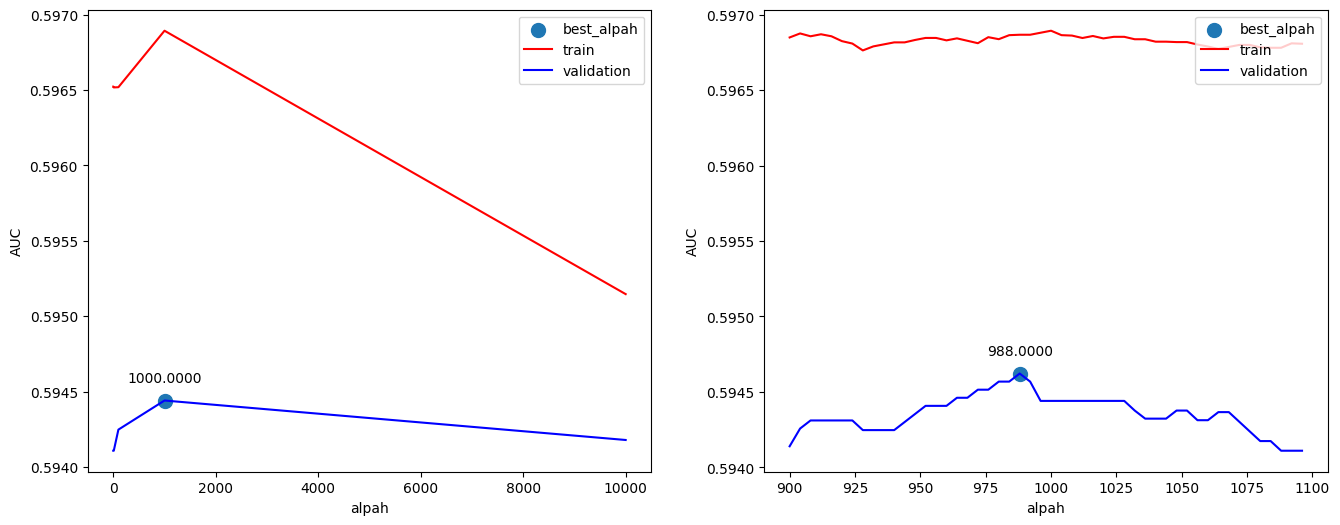

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Roughly search alphas
static = {"random_state": RANDOM_STATE}
dynamic = {"alpha": np.logspace(-1, 4, 6)}
params = params_wrapper(static, dynamic)
scores = get_scores(params, RidgeClassifier, **dataset)

print("Alpha:", dynamic["alpha"][np.argmax(scores.val_scores)])
print("Validation score:", np.max(scores.val_scores), "\n")
ax1 = plot_score(ax1, dynamic["alpha"], scores.train_scores, scores.val_scores, "alpah")

# Fine search alphas
dynamic = {"alpha": np.arange(900, 1100, 4)}
params = params_wrapper(static, dynamic)
scores = get_scores(params, RidgeClassifier, **dataset)

print("Best alpha:", dynamic["alpha"][np.argmax(scores.val_scores)])
print("Best validation score:", np.max(scores.val_scores))
ax2 = plot_score(ax2, dynamic["alpha"], scores.train_scores, scores.val_scores, "alpah")

plt.show()


左圖是進行粗略的搜尋，找到 alpha 大致是落在 1000 附近。再進行更精細的搜尋，找到最佳的 alpha 是 988。

從 AUC Score 與 alpha 的圖來看，alhpa = 988 的情況的確是最高的 Validation score，也就是說沒有 Overfitting。


### SGD Classifier

分為兩部分進行：

1. 使用 Halving Random Search 來在 Parameter distribution 的組合中找到適合的。
2. 繪製 AUC Score 與個別參數的關係圖來確認其的確為最合適的數值，且沒有 Overfitting 的情況。


In [6]:
# 固定參數，不納入 RandomSearch
static = {
    "penalty": "elasticnet",
    "learning_rate": "optimal",
    "max_iter": 2000,
    "early_stopping": True,
    "random_state": RANDOM_STATE,
    "n_jobs": -1,
}

# Using HalvingRandomSearchCV to find possible best parameters
param_distirbution = {
    "loss": ["hinge", "log_loss"],
    "alpha": sp.stats.uniform(0, 1),
    "l1_ratio": sp.stats.uniform(0, 1),
}

pipe_sgd = make_pipeline(
    StandardScaler(),
    HalvingRandomSearchCV(
        SGDClassifier(**static),
        param_distirbution,
        factor=4,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
)
pipe_sgd.fit(x_train.values, y_train.values.ravel())

# Combine the finding parameters and static parameters
tmp = static.copy()
tmp.update(pipe_sgd[1].best_params_)

scores = get_scores([tmp], SGDClassifier, **dataset)
print("Best validation score:", np.max(scores.val_scores))
print("Best train score:", np.max(scores.train_scores))


Best validation score: 0.5964125884114324
Best train score: 0.5967957403102518


Best alpha: 0.01780800621309664
Best l1_ratio: 0.2995445255982362
Best validation score: 0.5964125884114324


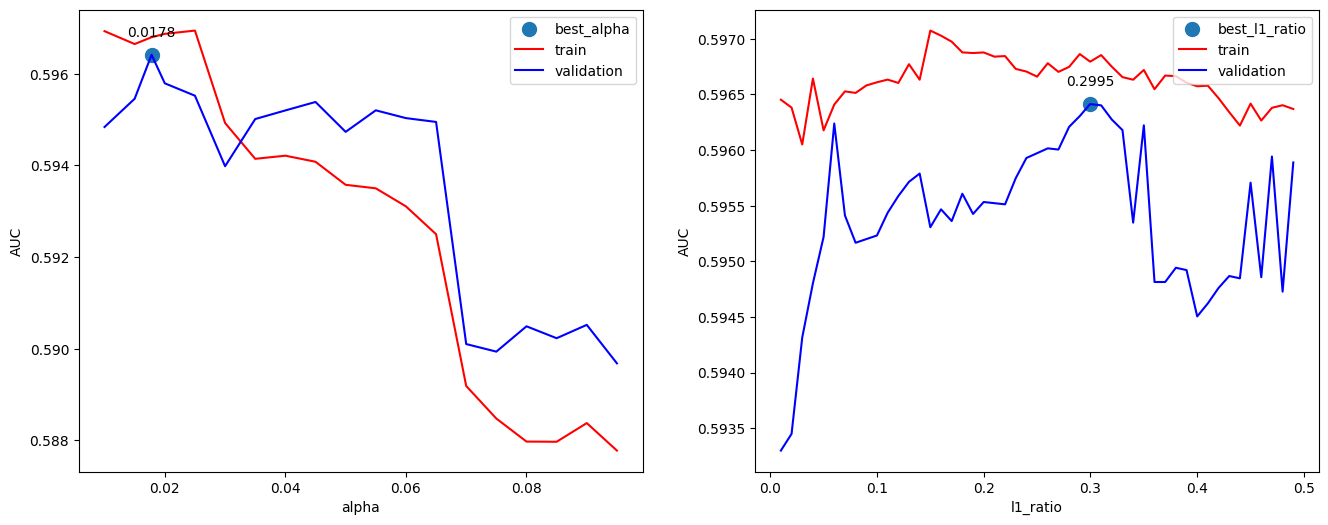

In [7]:
def generate_sgd_param_pair(dynamic_key, find, dynamic, static):
    values = np.sort(np.append(dynamic[dynamic_key], find[dynamic_key]))
    dynamic = {dynamic_key: values}
    find.pop(dynamic_key)
    static.update(find)

    @dataclass
    class param_pair:
        dynamic: dict
        static: dict

    return param_pair(dynamic, static)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Check parameters found above is best
find = pipe_sgd[1].best_params_
dynamic = {
    "alpha": np.arange(0.01, 0.1, 0.005),
    "l1_ratio": np.arange(0.01, 0.5, 0.01),
}

param_pair = generate_sgd_param_pair(
    "alpha", find.copy(), dynamic.copy(), static.copy()
)
params = params_wrapper(param_pair.static, param_pair.dynamic)
scores = get_scores(params, SGDClassifier, **dataset)

print("Best alpha:", find["alpha"])
print("Best l1_ratio:", find["l1_ratio"])
print("Best validation score:", np.max(scores.val_scores))

plot_score(
    ax1,
    param_pair.dynamic["alpha"],
    scores.train_scores,
    scores.val_scores,
    "alpha",
)

param_pair = generate_sgd_param_pair(
    "l1_ratio", find.copy(), dynamic.copy(), static.copy()
)
params = params_wrapper(param_pair.static, param_pair.dynamic)
scores = get_scores(params, SGDClassifier, **dataset)

plot_score(
    ax2,
    param_pair.dynamic["l1_ratio"],
    scores.train_scores,
    scores.val_scores,
    "l1_ratio",
)

plt.show()


上面兩張圖分別為固定 l1_ration 的 alpha，以及固定 alpha 的 l1_ratio。

從兩張圖來看，alpha 及 l1_ratio 兩個參數確實都是 local maxima。代表沒有 Overfitting 的問題。

而與參數相對應的 AUC Score 則大約是 0.5964。相比較起 Ridge classifier 的 AUC Score 稍微高了一點，因此後續將使用 SGD classifier。


## Feature selection & Retraining

分為三個部分：

1. 透過前面得到的模型中所提供的各特徵的 Weight 來對特徵評斷，並取出前三。
2. 基於選出特徵的資料集再度訓練，並繪製對應的 AUC Score 與參數的關係圖，以確認是否原先參數是否合適。
3. 如不合適，進行調整後再回到第二步。最後對 Test case 進行預測。


#### Feature selection

通過比較各特徵的 Weight，取其中絕對值最大的三者視為對模型影響最大的特徵。


In [8]:
# Using coefficients to find important features
coef = pipe_sgd[1].best_estimator_.coef_
importance = pd.Series(data=coef.ravel(), index=X_COL_NAMES)
features = importance.abs().nlargest(3).index
print(features.values)

dataset_selected = dataset.copy()
dataset_selected["x_train"] = dataset_selected["x_train"][features]
dataset_selected["x_val"] = dataset_selected["x_val"][features]


['SHOT_DIST' 'CLOSE_DEF_DIST' 'SHOT_CLOCK']


#### Retraining


Using alpha: 0.01780800621309664
Using l1_ratio: 0.2995445255982362
Validation score: 0.5953832442815289


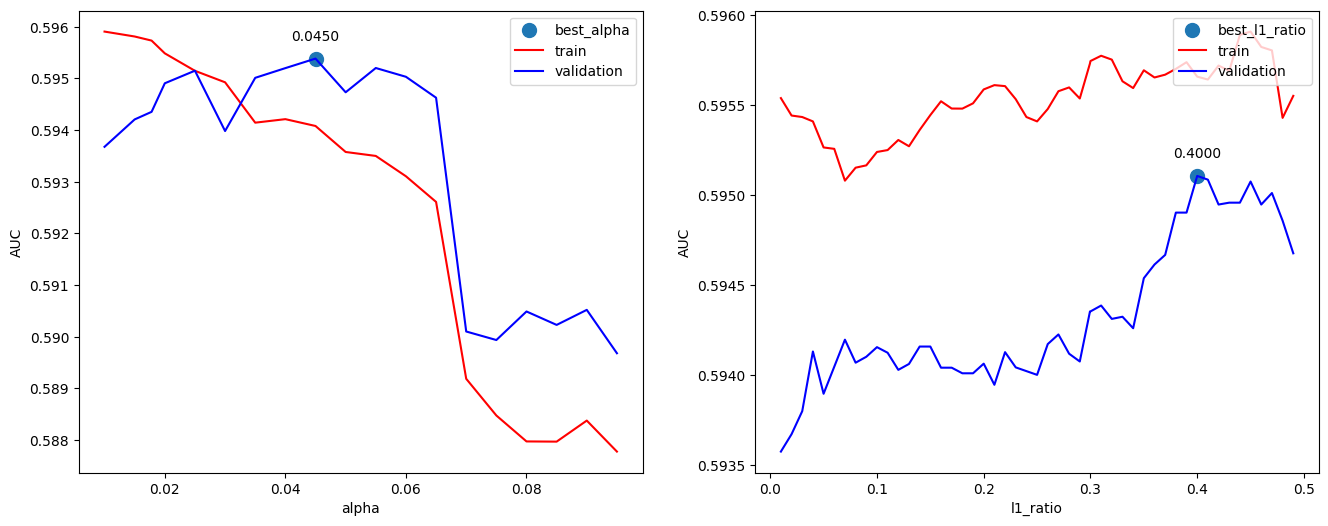

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Check parameters found above is best
find = pipe_sgd[1].best_params_
dynamic = {
    "alpha": np.arange(0.01, 0.1, 0.005),
    "l1_ratio": np.arange(0.01, 0.5, 0.01),
}

param_pair = generate_sgd_param_pair(
    "alpha", find.copy(), dynamic.copy(), static.copy()
)
params = params_wrapper(param_pair.static, param_pair.dynamic)
scores = get_scores(params, SGDClassifier, **dataset_selected)

print("Using alpha:", find["alpha"])
print("Using l1_ratio:", find["l1_ratio"])
print("Validation score:", np.max(scores.val_scores))

plot_score(
    ax1,
    param_pair.dynamic["alpha"],
    scores.train_scores,
    scores.val_scores,
    "alpha",
)

param_pair = generate_sgd_param_pair(
    "l1_ratio", find.copy(), dynamic.copy(), static.copy()
)
params = params_wrapper(param_pair.static, param_pair.dynamic)
scores = get_scores(params, SGDClassifier, **dataset_selected)

plot_score(
    ax2,
    param_pair.dynamic["l1_ratio"],
    scores.train_scores,
    scores.val_scores,
    "l1_ratio",
)

plt.show()


可以看到原先參數在新的資料集中並不在是 Local maxima，因此可以再進行 Optimal value 的尋找。

不過本次作業並沒有要求，且分數也並不是真的差別很大，因此我認為也還可以接受。


## Export the prediction

基於前面所找到的參數對 Test case 進行預測，並輸出成指定格式。


In [10]:
output_path = "./output/Lab05_112501533_y_pred.csv"

param = pipe_sgd[1].best_estimator_.get_params()
sgd_clf = make_pipeline(StandardScaler(), SGDClassifier(**param)).fit(
    x_read[features].values, y_read.values.ravel()
)
y_pred = sgd_clf.predict(X_test[features].values)

with open(output_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(Y_COL_NAMES)
    writer.writerows(y_pred.reshape(-1, 1))
